In [2]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets.copy() 
  
# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 
  
# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables) 


{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC','CALC','MTRANS']
# One-hot encode categorical features, dropping the first category
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})

# Convert X_encoded to a PyTorch tensor
X_tensor = torch.tensor(X_encoded.values, dtype=torch.float32)


In [5]:
y['NObeyesdad'] = y['NObeyesdad'].astype('category').cat.codes

# Convert to tensor
y_tensor = torch.tensor(y['NObeyesdad'].to_numpy(), dtype=torch.long)

In [6]:
x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

In [8]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=2, prior_scale=5.):
        super().__init__()
        self.in_dim = in_dim

        self.activation = nn.ReLU()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, self.in_dim)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        x = self.layers[-1](x).squeeze()  # hidden --> output
        x = torch.softmax(x, dim=1) # softmax activation
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(x), obs=y)
        return x

In [20]:
# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
model = BNN(in_dim = x_tr.shape[1], out_dim = 7, hid_dim=10, n_hid_layers=2, prior_scale=1)
#in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.

nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# define model and data

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=250, warmup_steps=500)
mcmc.run(x_tr, y_tr)


Sample: 100%|██████████| 750/750 [14:45,  1.18s/it, step size=1.02e-03, acc. prob=0.929]


In [21]:
post_samples = mcmc.get_samples()

keys = list(post_samples.keys())
print(keys)

post_samples[keys[1]].shape

['layers.0.bias', 'layers.0.weight', 'layers.1.bias', 'layers.1.weight', 'layers.2.bias', 'layers.2.weight']


torch.Size([250, 10, 23])

In [3]:
import pickle


# # Save dictionary to a pickle file
# with open('post_samples.pkl', 'wb') as f:
#     pickle.dump(post_samples, f)

In [4]:
# Load dictionary from the pickle file
with open('post_samples.pkl', 'rb') as f:
    loaded_samples = pickle.load(f)

In [24]:
y_te = y_te.float()

In [18]:
predictive(x_te)

{'obs': tensor([[0, 4, 0,  ..., 5, 1, 3],
         [0, 4, 0,  ..., 5, 1, 3],
         [0, 4, 0,  ..., 5, 1, 3],
         ...,
         [0, 4, 0,  ..., 5, 1, 3],
         [0, 4, 1,  ..., 5, 1, 3],
         [0, 4, 0,  ..., 5, 1, 3]])}

In [29]:
model(x_te,posterior_samples = loaded_samples)[0,:]

TypeError: BNN.forward() got an unexpected keyword argument 'posterior_samples'

In [15]:
predictive = Predictive(model=model, posterior_samples=loaded_samples)
preds = predictive(x_te)['obs']
mean_preds = preds.mean(0)
loss = nn.NLLLoss()
loss(mean_preds, y_te)

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

In [24]:
y_te[0]

tensor(0)

In [27]:
relative_frequencies = torch.zeros(7, 634)
for j in range(preds.shape[1]):
    # Count the occurrences of each label in column j
    label_counts = torch.bincount(preds[:, j], minlength=7)
    # Calculate the relative frequency by dividing by the total number of predictions (50)
    relative_frequencies[:, j] = label_counts.float() / preds.shape[0]

relative_frequencies

tensor([[0.9480, 0.0000, 0.8240,  ..., 0.0000, 0.0000, 0.0000],
        [0.0520, 0.0000, 0.1720,  ..., 0.1240, 0.9240, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0200],
        ...,
        [0.0000, 0.9920, 0.0000,  ..., 0.0000, 0.0000, 0.0320],
        [0.0000, 0.0000, 0.0040,  ..., 0.8760, 0.0760, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [23]:
import torch

def get_network_outputs(net_samples, input_data):
    """
    Computes the outputs of the neural network for each of the 250 sampled weights and biases.

    Parameters:
    - loaded_samples (dict): Dictionary with keys like 'layers.0.bias', 'layers.0.weight', etc.
    - input_data (torch.Tensor): Input data to feed into the network (shape [batch_size, input_dim]).

    Returns:
    - outputs (torch.Tensor): Network outputs for each sample (shape [250, batch_size, output_dim]).
    """
    # Initialize list to store outputs for all 250 samples
    outputs = []

    # Loop over each sample
    for i in range(loaded_samples['layers.0.bias'].shape[0]):  # 250 samples
        # Sample weights and biases
        layer_0_weight = loaded_samples['layers.0.weight'][i]  # Shape: [10, 23]
        layer_0_bias = loaded_samples['layers.0.bias'][i]      # Shape: [10]
        layer_1_weight = loaded_samples['layers.1.weight'][i]  # Shape: [23, X] (replace X with next layer size)
        layer_1_bias = loaded_samples['layers.1.bias'][i]      # Shape: [X] (same as layer_1_weight's output size)
        layer_2_weight = loaded_samples['layers.2.weight'][i]  # Shape: [X, output_dim]
        layer_2_bias = loaded_samples['layers.2.bias'][i]      # Shape: [output_dim]

        # Forward pass through the network for this sample
        x = input_data
        x = torch.matmul(x, layer_0_weight.T) + layer_0_bias  # First layer: shape [batch_size, 10]
        x = torch.relu(x)  # Activation function (ReLU)
        x = torch.matmul(x, layer_1_weight.T) + layer_1_bias  # Second layer
        x = torch.relu(x)  # Activation function (ReLU)
        x = torch.matmul(x, layer_2_weight.T) + layer_2_bias  # Third layer
        x = torch.softmax(x,dim=-1)
        # Store the output for this sample
        outputs.append(x)

    # Stack all outputs into a tensor (shape: [250, batch_size, output_dim])
    outputs = torch.stack(outputs)

    return outputs


In [45]:
preds = get_network_outputs(loaded_samples, x_te)

In [46]:
mean_preds = preds.mean(0)
mean_preds.shape

torch.Size([634, 7])

In [47]:
mean_preds_numpy = mean_preds.detach().numpy()

In [48]:
df = pd.DataFrame(
    mean_preds_numpy,  # Each column will be one of the 7 confidence values
    columns=[f'confidence_{i}' for i in range(mean_preds.shape[1])]
)
df['true_label'] = y_te  # Add the true labels
df.to_csv('obesity_preds_hmc.csv', index=False)

In [33]:
df = pd.read_csv('obesity_preds_hmc.csv')
plot_name = 'calibration_data_hmc'


In [34]:
df_melted = df.melt(id_vars=["true_label"], 
                    value_vars=["confidence_0", "confidence_1", "confidence_2", "confidence_3", 
                                "confidence_4", "confidence_5", "confidence_6"], 
                    var_name="pred_label", value_name="confidence")

# Extract the numerical part of the pred_label
df_melted["pred_label"] = df_melted["pred_label"].str.extract("(\d+)").astype(int)

# Reorder the columns to match the desired format
df_final = df_melted[["pred_label", "true_label", "confidence"]]

In [36]:
y_true = df_final.true_label.values
y_pred = df_final.pred_label.values
y_conf = df_final.confidence.values

In [37]:
# Override matplotlib default styling.
# plt.style.use("seaborn")

plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

In [38]:
def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins

    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.

    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.

    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float64)
    bin_confidences = np.zeros(num_bins, dtype=np.float64)
    bin_counts = np.zeros(num_bins, dtype=int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }

In [39]:
def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.

    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.

    The black line is the accuracy, the other end of the bar is the confidence.

    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.

    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.

    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance,
                                         draw_averages, title, figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig)


In [40]:
def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig

In [41]:
def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt])


In [42]:

def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
   
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])

C:\Users\peter\AppData\Local\Temp\ipykernel_20156\1827701276.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


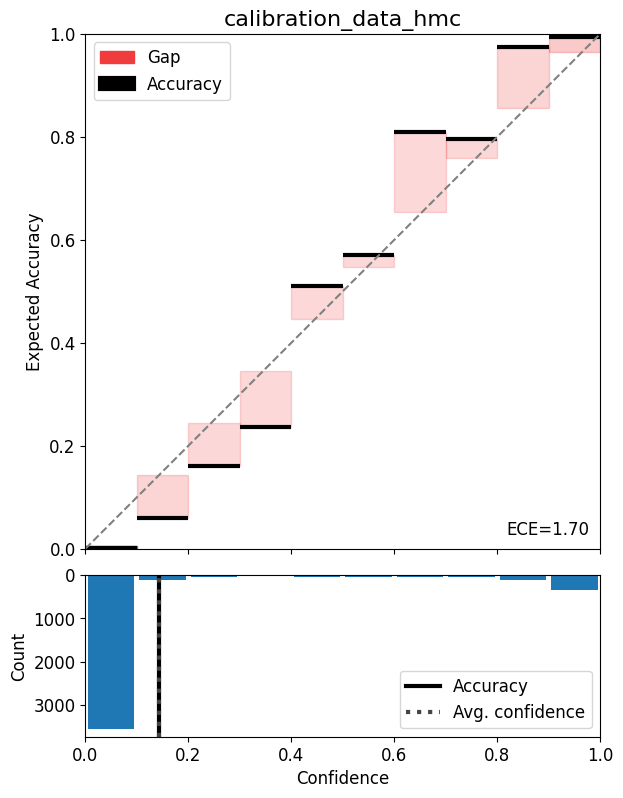

In [43]:
title = "\n".join(plot_name.split())

fig = reliability_diagram(y_true, y_pred, y_conf, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)

In [49]:
loss = nn.NLLLoss()
loss(torch.log(mean_preds),y_te)

tensor(0.2131)